In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import xgboost as xgb
import umap
import HomeMade as hm
from sklearn.metrics import roc_curve, roc_auc_score
import importlib
hm = importlib.reload(hm)

In [24]:
all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = 1e4)

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = 2e5)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.5)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_slice = int(len(mc)*0.5)
train_mc = mc[:train_test_slice]
test_mc = mc[train_test_slice:]

In [25]:
umap_feats = "pv0_x pv0_y pv0_z \
v0_x v0_y v0_z v0_px v0_py v0_pz v0_pt v0_p v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")
xgb_feats = "a0 a0xy cosTheta v0_chi2 v0_rxy v0_rxyErr".split(" ")

First try in MC so it's easier to draw ROC curve: (Did not do very well, seperation with umap is difficult on unseen data)

In [19]:
yumap = umap.UMAP(metric='mahalanobis',verbose=True,target_weight=0.1)
emb_train = yumap.fit_transform(train_mc[umap_feats],y=train_mc.trueKs)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='mahalanobis',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.1,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed Sep 30 17:36:05 2020 Finding Nearest Neighbors
Wed Sep 30 17:36:06 2020 Finished Nearest Neighbor Search
Wed Sep 30 17:36:06 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	complet

In [5]:
# cla = xgb.XGBClassifier()
# cla.fit(pd.concat([train_mc[xgb_feats],pd.DataFrame(emb_train,index=train_mc.index,columns=['x','y'])],axis=1),y=train_mc.trueKs)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [22]:
emb_test = yumap.transform(test_mc[umap_feats])
# p = cla.predict_proba(pd.concat([test_mc[xgb_feats],pd.DataFrame(emb_test,index=test_mc.index,columns=['x','y'])],axis=1))[:,1]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [ ]:
# fpr, tpr, threshold = roc_curve(test_mc.trueKs,p)
# fig, ax = plt.subplots()
# ax.plot(fpr,tpr)

In [31]:
# yumap = umap.UMAP(metric='mahalanobis',verbose=True,target_weight=0.5)
yumap = umap.UMAP(verbose=True,metric='mahalanobis')
emb_train = yumap.fit_transform(train_mc[umap_feats],y=train_mc.trueKs)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='mahalanobis',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed Sep 30 18:26:06 2020 Finding Nearest Neighbors
Wed Sep 30 18:26:06 2020 Building RP forest with 16 trees
Wed Sep 30 18:26:08 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	 8  /  16
	 9  /  16
	 10  /  16
	 11  /  16
	 12  /  16
	 13  /  16
	 14  /  16
	 15  /  16


C:\Users\jv97\anaconda3\lib\site-packages\umap\umap_.py:401: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  "Failed to correctly find n_neighbors for some samples."


Wed Sep 30 18:31:48 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Sep 30 18:32:21 2020 Finished embedding


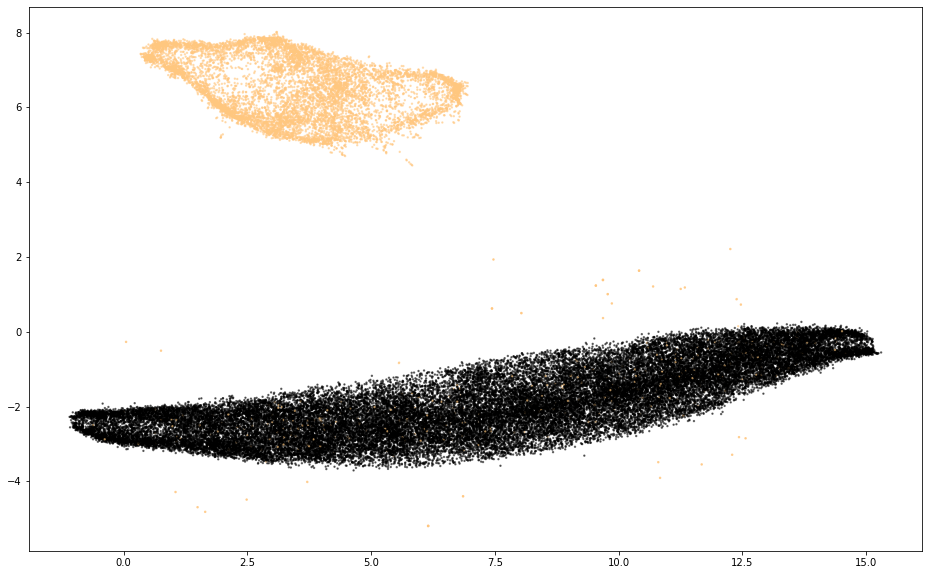

In [32]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(emb_train[:,0],emb_train[:,1],s=2,alpha=0.5,cmap='copper',c=train_mc.trueKs)

In [33]:
emb_test = yumap.transform(test_mc[umap_feats])

ValueError: cannot reshape array of size 784716 into shape (52319,15)

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(emb_test[:,0],emb_test[:,1],s=2,alpha=0.5,cmap='copper',c=test_mc.trueKs)